# GARCH and Index Returns

### Problem Description
Is GARCH a good model for index returns? Implement, estimate and verify a GARCH(1,1) for
SP 500 daily returns. Do not use any built-in Python functions. In detail . . .

• Write a general function that estimates a GARCH(1,1) for a time series, and that returns
the parameters, standard errors and the filtered variance process

• Download at least 15 years of daily SP 500 data and estimate the GARCH model

• Use the estimated parameters and the filtered volatility to simulate a 95% confidence interval
for a 30 day prediction period. Do this for every day in your sample

• Verify how often the realizations 30 days ahead violate the confidence interval. Make a plot

### Brief Guide to the Notebook
Data is downloaded directly from Yahoo Finance, so no CSV files are needed. We start with basic statistics and visualizations of the SP500 data, then move to the GARCH(1,1) model. Returns and 95% confidence intervals are simulated using the estimated parameters, and we check how often actual returns fall outside the intervals. Both normal and Student’s t-distributed shocks are tested, as the data shows heavy tails. Key formulas and notes are included in markdown chunks for clarity, making each step easy to follow. A brief reflection on the results is provided at the end. For more details and a full explanation, please refer to the report.

### Libraries

In [117]:
# pip install numpy
# pip install pandas
# pip install matplotlib
# pip install seaborn
# pip install yfinance
# pip install scipy
# pip install statsmodels

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import t as t_distribution # t is already used in the code, this avoids confusion
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.special import gammaln

### Download Data from Yahoo Finance

In [119]:
sp500_data = yf.download("^GSPC", start="1985-01-01", end="2000-12-31")

[*********************100%***********************]  1 of 1 completed


### Descriptive Statistics

In [120]:
sp500_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
1985-01-02,165.369995,165.369995,167.199997,165.190002,167.199997,67820000
1985-01-03,164.570007,164.570007,166.110001,164.380005,165.369995,88880000
1985-01-04,163.679993,163.679993,164.550003,163.360001,164.550003,77480000
1985-01-07,164.240005,164.240005,164.710007,163.679993,163.679993,86190000
1985-01-08,163.990005,163.990005,164.589996,163.910004,164.240005,92110000


In [121]:
sp500_data.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2000-12-22,1305.949951,1305.949951,1305.969971,1274.859985,1274.859985,1087100000
2000-12-26,1315.189941,1315.189941,1315.939941,1301.640015,1305.969971,806500000
2000-12-27,1328.920044,1328.920044,1332.030029,1310.959961,1315.189941,1092700000
2000-12-28,1334.219971,1334.219971,1335.930054,1325.780029,1328.920044,1015300000
2000-12-29,1320.280029,1320.280029,1340.099976,1317.510010,1334.219971,1035500000


In [122]:
# Check for missing values
sp500_data.isnull().sum()

Price      Ticker
Adj Close  ^GSPC     0
Close      ^GSPC     0
High       ^GSPC     0
Low        ^GSPC     0
Open       ^GSPC     0
Volume     ^GSPC     0
dtype: int64

In [123]:
# Table for descriptive statistics
descriptive_statistic_sp500 = sp500_data.describe().style.format("{:.2f}").set_caption("Descriptive Statistics for S&P 500 Data")
descriptive_statistic_sp500

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
count,4043.00,4043.00,4043.00,4043.00,4043.00,4043.00
mean,578.63,578.63,582.05,574.51,578.34,353407014.59
std,381.57,381.57,384.79,377.99,381.45,273880915.67
min,163.68,163.68,164.55,163.36,163.68,14990000.00
25%,304.32,304.32,306.09,301.67,304.02,159120000.00
50%,434.52,434.52,435.75,432.65,434.34,236520000.00
75%,750.21,750.21,755.56,746.34,749.93,465875000.00
max,1527.46,1527.46,1552.87,1518.46,1527.46,1561100000.00


In [124]:
print(len(sp500_data))

4043


### Log Returns

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:
- $r_t$: Daily log return.
- $P_t$: Adjusted closing price at time $t$.
- $P_{t-1}$: Adjusted closing price at time $t-1$.

In [125]:
# Daily log returns
sp500_data['Daily Log Return'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1)) 

# Drop first row with missing value
sp500_data = sp500_data.dropna()

# Re-check lenght
print(len(sp500_data))

4042


### Compute Average and De-Mean 
We simplify the calculations by de-meaning the data and then assuming that the mean return (μ) estimated by the GARCH model is always zero.

In [126]:
# Check the average of daily log returns 
average_log_return = sp500_data['Daily Log Return'].mean()
print("Average Daily Log Return:", average_log_return)

# Demean the log returns by subtracting the average
sp500_data['Daily Log Return'] = sp500_data['Daily Log Return'] - average_log_return

# Define returns for the GARCH model
returns = sp500_data['Daily Log Return'].values 

# Check the new average
print("Average Returns Demeaned:", returns.mean())

Average Daily Log Return: 0.0005139568971678373
Average Returns Demeaned: 8.240151098158015e-20


### Plotting 

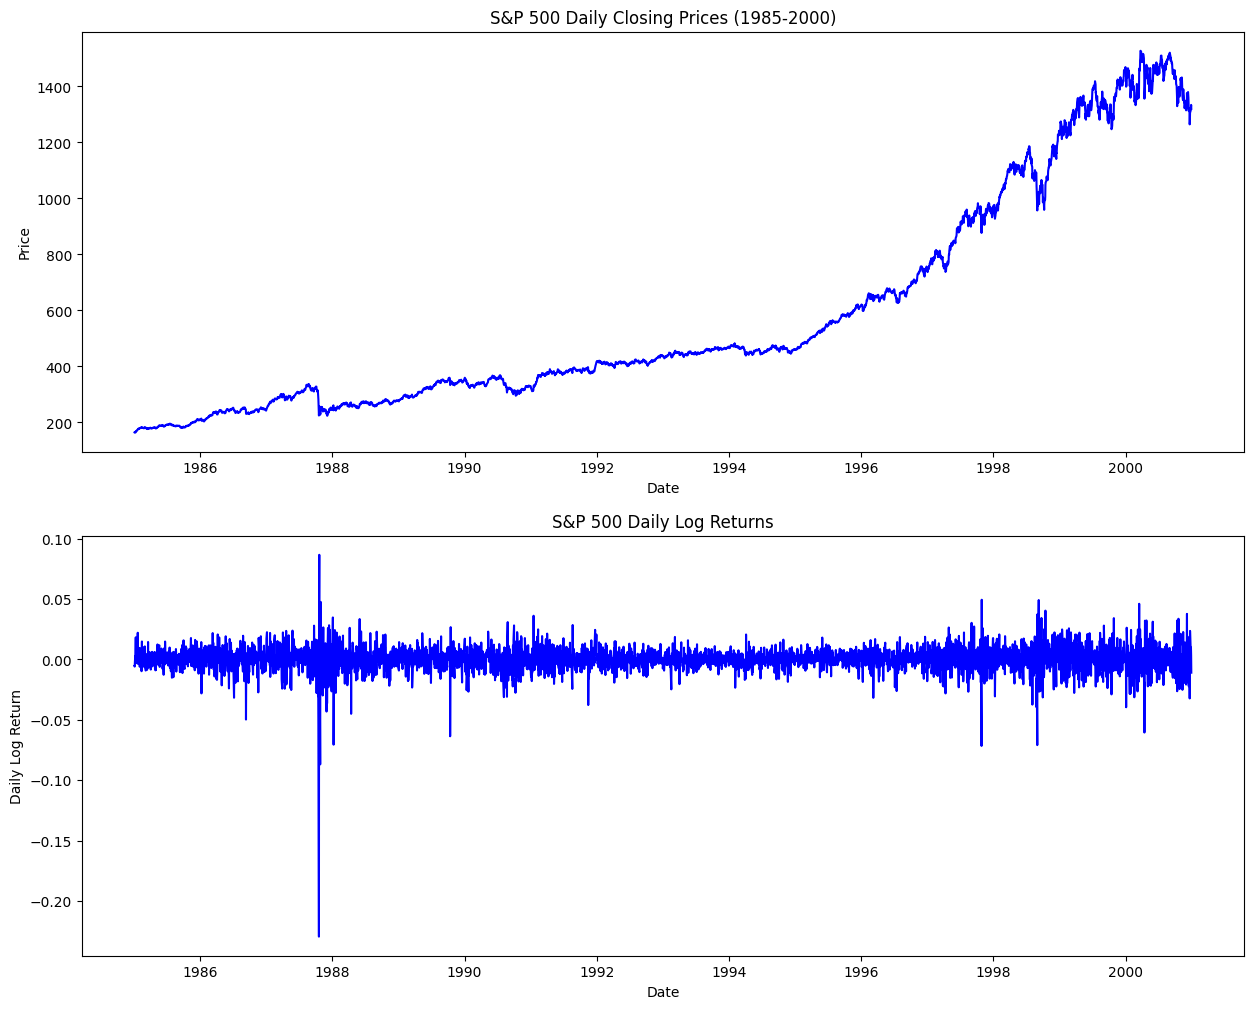

In [127]:
plt.figure(figsize=(15, 12))

# Plot S&P 500 daily closing prices
plt.subplot(2,1,1)
plt.plot(sp500_data['Adj Close'], color='blue')
plt.title("S&P 500 Daily Closing Prices (1985-2000)")
plt.xlabel("Date")
plt.ylabel("Price")

# Plot daily log returns
plt.subplot(2,1,2)
plt.plot(sp500_data['Daily Log Return'], color='blue')
plt.title("S&P 500 Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Daily Log Return")

plt.show()

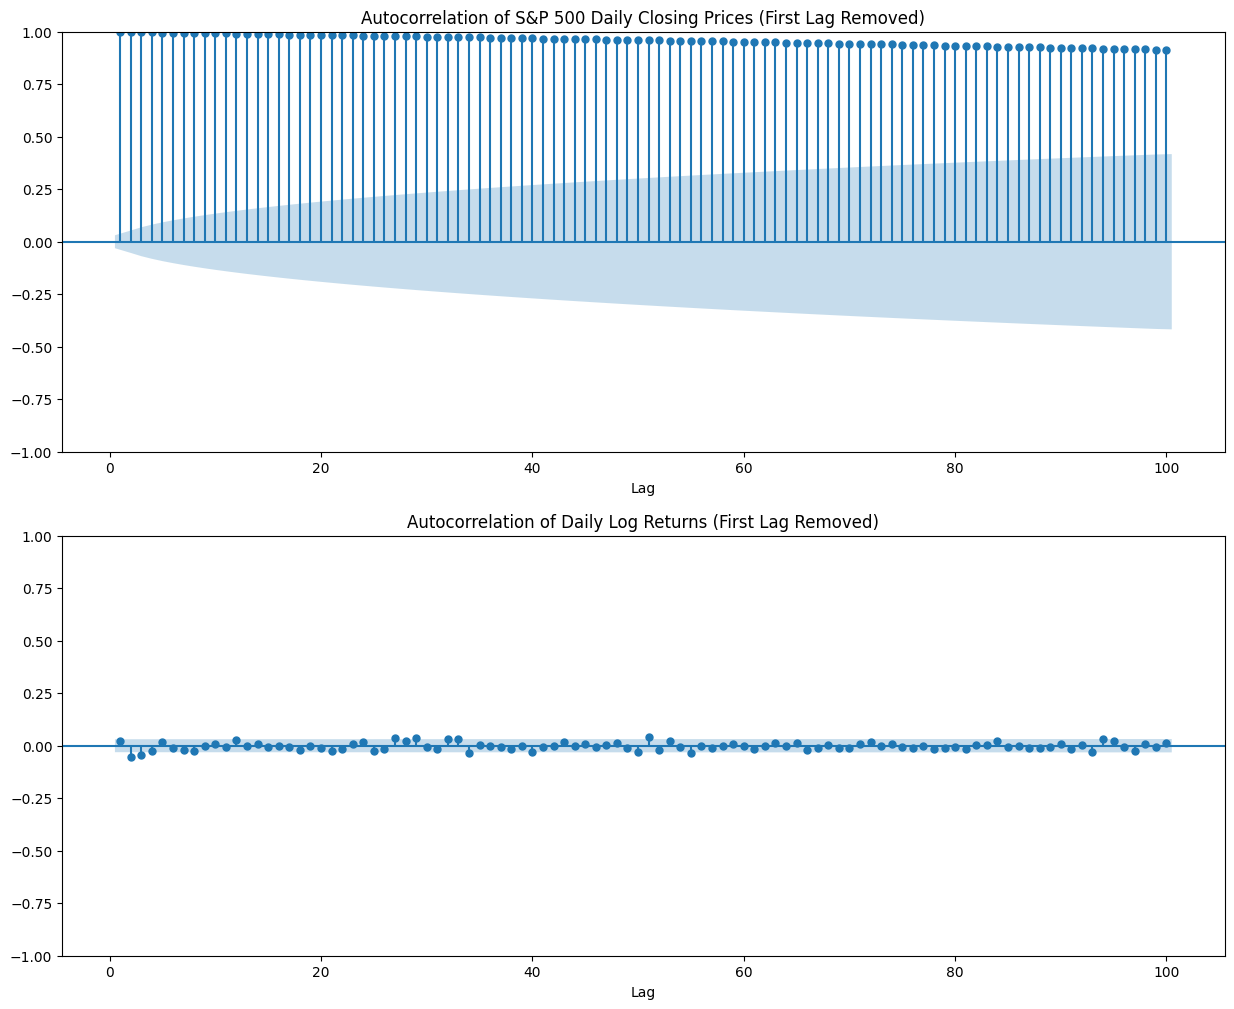

In [128]:
plt.figure(figsize=(15, 12))

# Autocorrelation of S&P 500 daily closing prices
plt.subplot(2,1,1)
plot_acf(sp500_data['Adj Close'], lags=100, zero=False, ax=plt.gca())
plt.title("Autocorrelation of S&P 500 Daily Closing Prices (First Lag Removed)")
plt.xlabel("Lag")

# Autocorrelation of daily log returns
plt.subplot(2,1,2)
plot_acf(sp500_data['Daily Log Return'], lags=100, zero=False, ax=plt.gca())
plt.title("Autocorrelation of Daily Log Returns (First Lag Removed)")
plt.xlabel("Lag")

plt.show()

### GARCH(1,1) Under Normality Assumption

#### Model Definition
The GARCH(1,1) model is defined as:

$$
r_t = \sigma_t z_t, \quad z_t \sim N(0, 1)
$$

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

Where:
- $r_t$ = return at time $t$
- $\sigma_t^2$ = conditional variance of $r_t$
- $z_t$ = standard normal random variable
- $\mathcal{F}_{t-1}$ = information set up to time $t-1$

Typical constraints:
- $\omega > 0, \alpha \geq 0, \beta \geq 0$, and $\alpha + \beta < 1$

---

#### Derive the PDF of $r_t \mid \mathcal{F}_{t-1}$

Since $z_t \sim N(0, 1)$, we have:

$$
r_t \mid \mathcal{F}_{t-1} \sim N(0, \sigma_t^2)
$$

#### General PDF of a Normal Distribution
The probability density function (PDF) of a normal random variable is given by:

$$
f(r_t \mid \mathcal{F}_{t-1}) = \frac{1}{\sqrt{2\pi \sigma_t^2}} \exp\left(-\frac{r_t^2}{2\sigma_t^2}\right)
$$

#### Log-Likelihood Function

The likelihood function for $T$ observations is:

$$
L(\theta) = \prod_{t=1}^T f(r_t \mid \mathcal{F}_{t-1})
$$

where $\theta = (\omega, \alpha, \beta)$. Taking the logarithm:

$$
\ell(\theta) = \ln L(\theta) = \sum_{t=1}^T \ln f(r_t \mid \mathcal{F}_{t-1})
$$

Substituting the PDF:

$$
\ell(\theta) = \sum_{t=1}^T \left[ -\frac{1}{2} \ln(2\pi) - \frac{1}{2} \ln(\sigma_t^2) - \frac{r_t^2}{2\sigma_t^2} \right]
$$


### GARCH(1,1) Function

In this script, `t` consistently represents a **time step**, aligning with standard mathematical notation in time series models. To avoid confusion and conflicts, we used `from scipy.stats import t as t_distribution` at the beginning.

In [129]:
def fit_garch_model(returns):
    # Define the log-likelihood function
    def garch_log_likelihood(parameters, returns):
        # Unpack parameters omega, alpha, beta
        omega, alpha, beta = parameters
        T = len(returns)
        var = np.zeros(T)  # Array to store variances
        var[0] = np.var(returns)  # Initialize variance using sample variance
        log_likelihood = 0  # Initialize log-likelihood

        # Compute log-likelihood using the GARCH(1,1) recursion
        for t in range(1, T):
            var[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * var[t - 1]
            log_likelihood += -0.5 * (
                np.log(2 * np.pi) + np.log(var[t]) + (returns[t]) ** 2 / var[t]
            )

        return -log_likelihood  # Return the negative log-likelihood for minimization

    # Initial guesses for parameters omega, alpha, beta
    initial_parameter_guess = [0.01, 0.05, 0.9]  
    bounds = [
        (1e-8, np.inf),     # omega must be positive
        (0, 1),             # alpha must be between 0 and 1
        (0, 1)              # beta must be between 0 and 1 
    ]

    # Minimize the negative log-likelihood function
    result = minimize(
        garch_log_likelihood, 
        initial_parameter_guess,
        args=(returns,),  # Pass returns as an argument 
        bounds=bounds,
        method='L-BFGS-B'  # Optimization method
    )

    # Extract estimated parameters and compute standard errors 
    parameters = result.x  # Optimized parameters
    hessian_inverse = result.hess_inv.todense() if hasattr(result.hess_inv, "todense") else np.linalg.inv(result.hess_inv)
    standard_errors = np.sqrt(np.diag(hessian_inverse))  # Standard errors from the Hessian matrix 

    # Unpack parameters for interpretation
    omega, alpha, beta = parameters

    # Filter variance using the GARCH recursion with parameters
    T = len(returns)
    filtered_variance = np.zeros(T)  # Array to store filtered variances
    filtered_variance[0] = np.var(returns)  # Initialize with sample variance

    # Apply the GARCH(1,1) variance equation recursively 
    for t in range(1, T):
        filtered_variance[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * filtered_variance[t - 1]

    return parameters, standard_errors, filtered_variance

In [ ]:
# Call the function
parameters, standard_errors, filtered_variance = fit_garch_model(returns)

# Display estimated parameters
print("Estimated Parameters:")
print(f"omega: {parameters[0]:.6f}")
print(f"alpha: {parameters[1]:.6f}")
print(f"beta: {parameters[2]:.6f}")

# Display standard errors
print("\nStandard Errors:")
print(f"{standard_errors[0]:.6f}")
print(f"{standard_errors[1]:.6f}")
print(f"{standard_errors[2]:.6f}")

# Display the first 10 values of the filtered variance process
print("\nFiltered Variance (First 10 Values):")
for i in range(10):
    print(f"Day {i + 1}: {filtered_variance[i]:.6f}")

Estimated Parameters:
omega: 0.000001
alpha: 0.087099
beta: 0.904394

Standard Errors:
0.062873
125.669065
1059.420593

Filtered Variance (First 10 Values):
Day 1: 0.000109
Day 2: 0.000103
Day 3: 0.000097
Day 4: 0.000090
Day 5: 0.000083
Day 6: 0.000081
Day 7: 0.000103
Day 8: 0.000096
Day 9: 0.000107
Day 10: 0.000098


### 30 Days Simulation Logic

Simulation:
   - Start with filtered variance ($\sigma_t^2$) for each day
   - Generate random shocks $z_t \sim N(0,1)$ and compute returns $r_t = \sqrt{\sigma_t} \cdot z_t$
   - Update variance using GARCH(1,1) $ \sigma_t^2 = \omega + \alpha r_t^2 + \beta \sigma_t^2 $ with previously estimated parameters and repeat the loop for 30 days
        
Alignment:
   - Each simulated return $r_t$ contributes to confidence intervals 
   - Align values to their corresponding to their respective days using `aligned_simulations`

Output:
- `simulated_returns`: A matrix where each row contains the 30 simulated returns for the corresponding day
- `aligned_simulations`: A list where each day aggregates overlapping simulated returns for confidence intervals


In [131]:
# Set a seed for reproducibility
np.random.seed(123)

# GARCH parameters
omega = 0.000001
alpha = 0.087099
beta = 0.904394

sample_days = len(returns)  # We repeat simulations for each day in our sample
prediction_period = 30 

# Initialize array to store simulated returns
simulated_returns = np.zeros((sample_days, prediction_period))  
aligned_simulations = [[] for _ in range(sample_days)]  # List to store overlapping simulations for each day

# Simulate returns for each day in the dataset
for day in range(sample_days):
    sigma_t = filtered_variance[day]  # Use day's filtered variance as the starting variance
    simulated_returns_temporary = []  # Temporary variable to store returns for this day
    
    for t in range(prediction_period):
        z_t = np.random.normal(0, 1)  
        r_t = np.sqrt(sigma_t) * z_t  
        simulated_returns_temporary.append(r_t)  # Store in the temporary list
        
        # Update variance using GARCH(1,1) formula
        sigma_t = omega + alpha * (r_t ** 2) + beta * sigma_t  
        
        # Align values (add this simulated return to the corresponding day in aligned_simulations)
        if day + t < sample_days:  # Ensure no out-of-bounds indexing
            aligned_simulations[day + t].append(r_t)
    
    # Store simulated returns for the day
    simulated_returns[day, :] = simulated_returns_temporary

### CI and Violation Rate 

Confidence Interval:
   - For each day, compute the standard deviation $\sigma$ of the aligned simulated returns
   - Use this standard deviation to calculate the 95% confidence interval CI
     $ \text{Lower Bound} = -1.96 \cdot \sigma, \quad \text{Upper Bound} = +1.96 \cdot \sigma $

Counting Violations:
   - A violation occurs if the observed return ($r_t$) falls outside the confidence interval
     $ r_t < \text{Lower Bound} \quad \text{or} \quad r_t > \text{Upper Bound} $
   - Iterate over all days in the sample and count the total number of violations

Output:
- `lower_bounds` and `upper_bounds`: Arrays containing the confidence interval bounds for each day
- `violations`: Total number of days where the observed return falls outside the confidence interval
- `violation_rate`: The percentage of days with violations, calculated as
  $ \text{Violation Rate} = \frac{\text{Total Violations}}{\text{Total Sample Days}} $


In [133]:
# Initialize variables 
lower_bounds = np.zeros(sample_days)
upper_bounds = np.zeros(sample_days)
violations = 0

# Calculate CIs and check for violations
for day in range(sample_days):
    if aligned_simulations[day]:  # Ensure there are aligned values
        simulated_values = np.array(aligned_simulations[day])  
        sigma = np.std(simulated_values)
        
        # Compute lower and upper bounds
        lower_bounds[day] = - 1.96 * sigma
        upper_bounds[day] = + 1.96 * sigma
        
        # Check for violation
        if returns[day] < lower_bounds[day] or returns[day] > upper_bounds[day]:
            violations += 1

# Calculate violation rate
violation_rate = violations / sample_days
print(f"Violation Rate: {violation_rate:.2%}")

Violation Rate: 5.81%


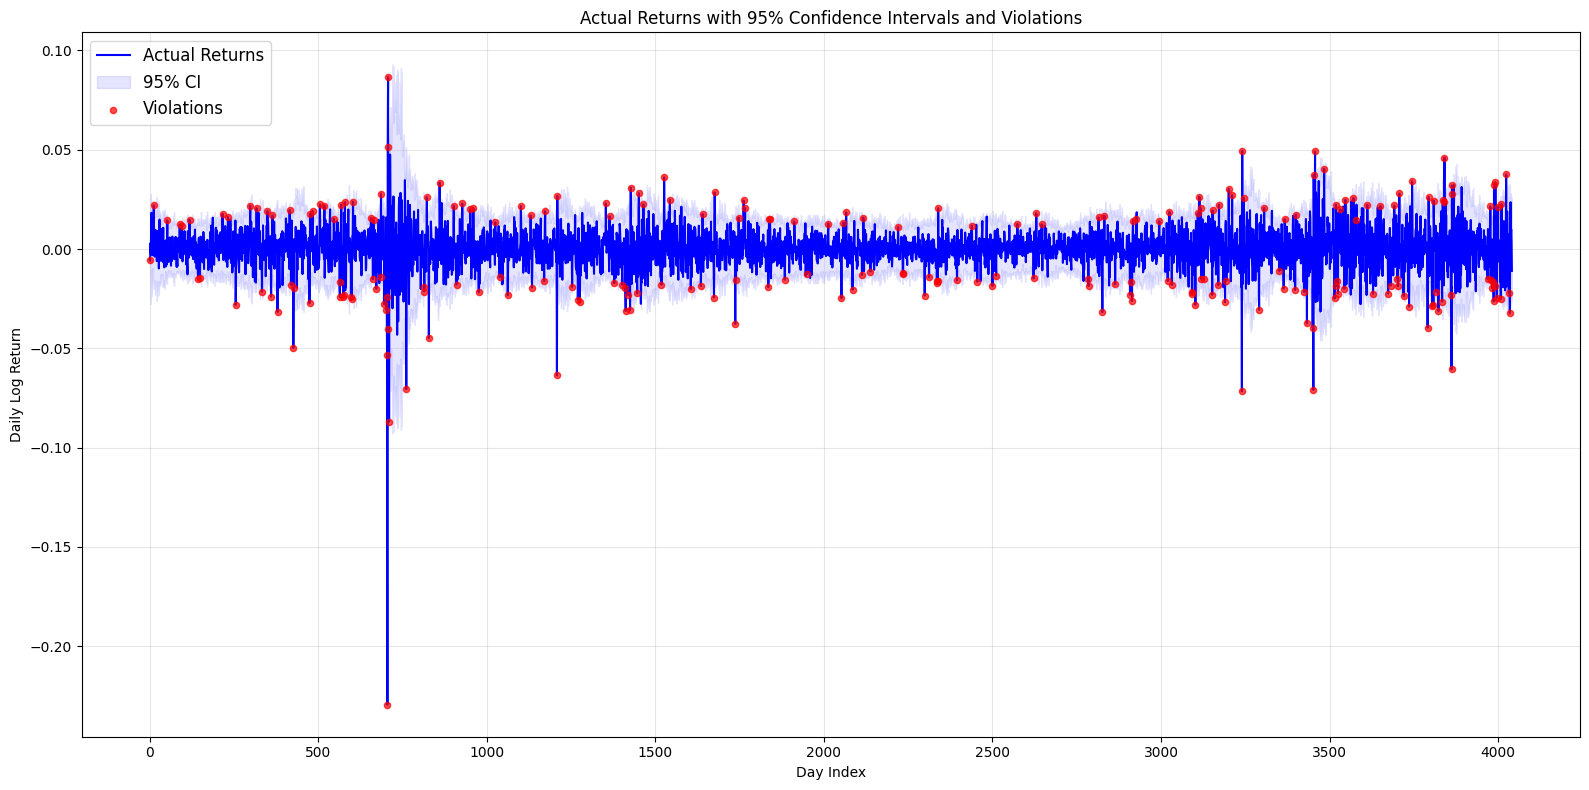

In [134]:
plt.figure(figsize=(16, 8))  

# Plot actual returns
plt.plot(range(sample_days), returns, label="Actual Returns", color="blue", linewidth=1.5)

# Add confidence interval 
plt.fill_between(range(sample_days), lower_bounds, upper_bounds, color="blue", alpha=0.1, label="95% CI")

# Highlight violations
violation_days = np.where((returns < lower_bounds) | (returns > upper_bounds))[0]
plt.scatter(violation_days, returns[violation_days], color="red", alpha = 0.7, label="Violations", zorder=5, s=20)

# Add labels, legend, and grid
plt.xlabel("Day Index")
plt.ylabel("Daily Log Return")
plt.title("Actual Returns with 95% Confidence Intervals and Violations")
plt.legend(fontsize=12, loc="upper left")
plt.grid(alpha=0.3)  

plt.tight_layout()
plt.show()

### Returns Distribution

In this second part of the study, we aim to fit a GARCH(1,1) model with Student's t-distributed shocks. We begin by examining the distributions of the returns and empirical shocks, which often exhibit "heavy tails", indicating deviations from normality.

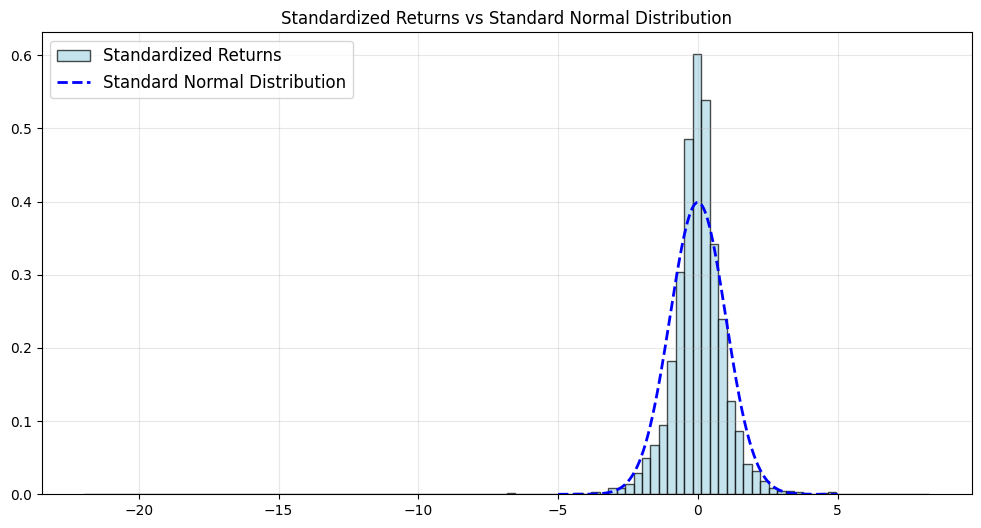

In [135]:
# Standardize the returns
mean_returns = np.mean(returns)
std_returns = np.std(returns)
standardized_returns = (returns - mean_returns) / std_returns

# Define the standard normal distribution
x = np.linspace(-5, 5, 1000)
normal_pdf = norm.pdf(x)  

plt.figure(figsize=(12, 6))

plt.hist(
    standardized_returns, 
    bins=100,  
    density=True, 
    color='lightblue', 
    alpha=0.7,  
    label='Standardized Returns',
    edgecolor='black'  
)

# Plot the standard normal distribution
plt.plot(x, normal_pdf, 'b--', linewidth=2, label='Standard Normal Distribution')

# Add labels, legend, and grid
plt.title('Standardized Returns vs Standard Normal Distribution')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.show()

### Innovations Distribution
The GARCH model innovations show significantly less volatility clustering compared to market returns. Additionally, the histogram indicates that the innovations deviate from a normal distribution.

In [136]:
# Compute innovations
innovations = returns / np.sqrt(filtered_variance)  

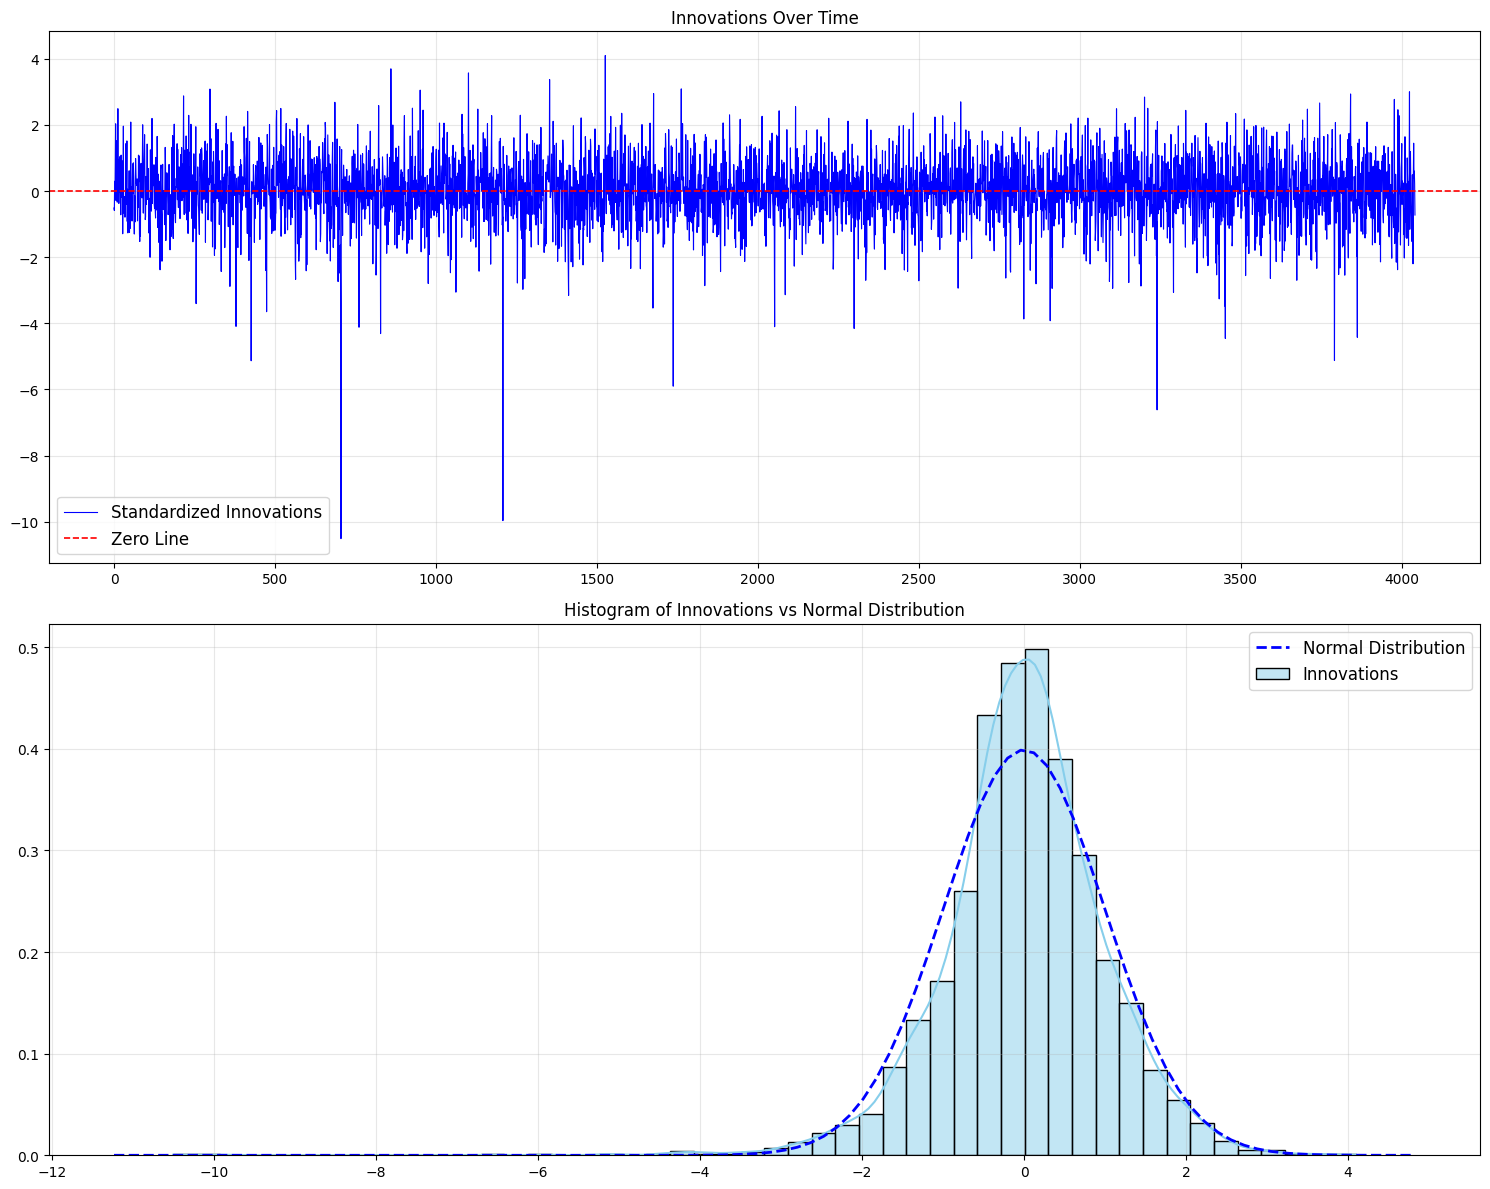

In [137]:
plt.figure(figsize=(15, 12))

# Plot innovations over time
plt.subplot(2, 1, 1)
plt.plot(innovations, color='blue', linewidth=0.8, label='Standardized Innovations')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.2, label='Zero Line')
plt.title("Innovations Over Time")
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Histogram of innovations vs normal distribution
plt.subplot(2, 1, 2)
sns.histplot(innovations, bins=50, kde=True, stat="density", color='skyblue', label="Innovations")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)  # Normal PDF with mean 0 and variance 1
plt.plot(x, p, 'b--', linewidth=2, label="Normal Distribution")
plt.title("Histogram of Innovations vs Normal Distribution")
plt.ylabel('')  # Remove y-axis title
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### GARCH(1,1) Under Student's t Assumption

#### Model Definition

The GARCH(1,1) model becomes:

$$
r_t = \sigma_t z_t, \quad z_t \sim t_\nu,
$$

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

Where:
- $t_\nu$ = Student-$t$ distribution with $\nu$ degrees of freedom.

---

#### Derive the PDF of $r_t \mid \mathcal{F}_{t-1}$

Since $z_t \sim t_\nu$, we have:

$$
r_t \mid \mathcal{F}_{t-1} = \sigma_t z_t
$$

The PDF of a scaled Student-$t$ distribution is:

$$
f(r_t \mid \mathcal{F}_{t-1}) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{\nu \pi} \sigma_t} \left(1 + \frac{r_t^2}{\nu \sigma_t^2}\right)^{-\frac{\nu+1}{2}}
$$

Where:
- $\Gamma(\cdot)$ = Gamma function
- $\nu$ = degrees of freedom

#### Log-Likelihood Function

The new log-likelihood becomes:

$$
\ell(\theta, \nu) = \sum_{t=1}^T \left[ \ln \Gamma\left(\frac{\nu+1}{2}\right) - \ln \Gamma\left(\frac{\nu}{2}\right) - \frac{1}{2} \ln(\nu \pi) - \frac{1}{2} \ln(\sigma_t^2) - \frac{\nu+1}{2} \ln\left(1 + \frac{r_t^2}{\nu \sigma_t^2}\right) \right]
$$

### Garch(1,1) Function

In [138]:
def fit_garch_model(returns):
    # Define the log-likelihood function for GARCH(1,1) with Student's t-distribution
    def garch_log_likelihood(parameters, returns):
        # Unpack parameters omega, alpha, beta, nu
        omega, alpha, beta, nu = parameters
        T = len(returns)
        var = np.zeros(T)  # Array to store variances
        var[0] = np.var(returns)  # Initialize variance using sample variance
        log_likelihood = 0  # Initialize log-likelihood

        # Compute new log-likelihood 
        for t in range(1, T):
            var[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * var[t - 1]
            # Log of the Student's t PDF
            log_likelihood += (
                gammaln((nu + 1) / 2)
                - gammaln(nu / 2)
                - 0.5 * np.log(np.pi * (nu - 2))
                - 0.5 * np.log(var[t])
                - ((nu + 1) / 2) * np.log(1 + (returns[t] ** 2) / ((nu - 2) * var[t]))
            )

        return -log_likelihood  # Return the negative log-likelihood for minimization

    # Initial guesses for parameters omega, alpha, beta, nu
    initial_parameter_guess = [0.01, 0.05, 0.9, 10]  # Add an initial guess for nu
    bounds = [
        (1e-8, np.inf),  # omega must be positive
        (0, 1),          # alpha must be between 0 and 1
        (0, 1),          # beta must be between 0 and 1
        (2 + 1e-8, np.inf)  # nu > 2 for the t-distribution to be well-defined
    ]

    # Minimize the negative log-likelihood function
    result = minimize(
        garch_log_likelihood,
        initial_parameter_guess,
        args=(returns,),  # Pass returns as an argument
        bounds=bounds,
        method='L-BFGS-B'  # Optimization method
    )

    # Extract estimated parameters and compute standard errors
    parameters = result.x  # Optimized parameters
    hessian_inverse = result.hess_inv.todense() if hasattr(result.hess_inv, "todense") else np.linalg.inv(result.hess_inv)
    standard_errors = np.sqrt(np.diag(hessian_inverse))  # Standard errors from the Hessian matrix

    # Unpack parameters for interpretation
    omega, alpha, beta, nu = parameters

    # Filter variance using the GARCH recursion with parameters
    T = len(returns)
    filtered_variance = np.zeros(T)  # Array to store filtered variances
    filtered_variance[0] = np.var(returns)  # Initialize with sample variance

    # Apply the GARCH(1,1) variance equation recursively
    for t in range(1, T):
        filtered_variance[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * filtered_variance[t - 1]

    return parameters, standard_errors, filtered_variance

In [ ]:
# Call the function
parameters, standard_errors, filtered_variance = fit_garch_model(returns)

# Display estimated parameters
print("Estimated Parameters:")
print(f"omega: {parameters[0]:.6f}")
print(f"alpha: {parameters[1]:.6f}")
print(f"beta: {parameters[2]:.6f}")
print(f"nu(degrees of freedom): {parameters[3]:.6f}")

# Display standard errors
print("\nStandard Errors:")
print(f"{standard_errors[0]:.6f}")
print(f"{standard_errors[1]:.6f}")
print(f"{standard_errors[2]:.6f}")
print(f"{standard_errors[3]:.6f}")

# Display the first 10 values of the filtered variance process
print("\nFiltered Variance (First 10 Values):")
for i in range(10):
    print(f"Day {i + 1}: {filtered_variance[i]:.6f}")

Estimated Parameters:
omega: 0.000001
alpha: 0.047820
beta: 0.946743
nu(degrees of freedom): 5.243100

Standard Errors:
0.215820
285.858143
4124.552155
60013.559525

Filtered Variance (First 10 Values):
Day 1: 0.000109
Day 2: 0.000105
Day 3: 0.000102
Day 4: 0.000098
Day 5: 0.000093
Day 6: 0.000091
Day 7: 0.000103
Day 8: 0.000098
Day 9: 0.000104
Day 10: 0.000100


### 30 Days Simulation Logic

This process is exactly identical to the normal GARCH simulation, but we use the parameters estimated from the Student's t-GARCH model and draw shocks from the Student's t-distribution instead of the normal distribution.

In [140]:
# Set a seed for reproducibility
np.random.seed(123)

# New GARCH parameters
omega = 0.000001
alpha_1 = 0.047820
beta_1 = 0.946743
nu = 5.243100  # Degrees of freedom for the Student's t-distribution

# Simulation setup
sample_days = len(returns)  # We repeat simulations for each day in our sample
prediction_period = 30  # Number of days for forward predictions

# Initialize array to store simulated returns
simulated_returns = np.zeros((sample_days, prediction_period))  
aligned_simulations = [[] for _ in range(sample_days)]  # List to store overlapping simulations for each day

# Simulate returns for each day in the dataset
for day in range(sample_days):
    sigma_t = filtered_variance[day]  # Use day's filtered variance as the starting variance
    simulated_returns_temporary = []  # Temporary variable to store returns for this day
    
    for t in range(prediction_period):
        # Generate random shocks from a standardized Student's t-distribution
        z_t = np.random.standard_t(nu)  # Random variable with Student's t-distribution
        r_t = np.sqrt(sigma_t) * z_t  # Simulate return with current variance
        
        simulated_returns_temporary.append(r_t)  # Store in the temporary list
        
        # Update variance using the GARCH(1,1) formula
        sigma_t = omega + alpha_1 * (r_t ** 2) + beta_1 * sigma_t  # GARCH recursion
        
        # Align values (add this simulated return to the corresponding day in aligned_simulations)
        if day + t < sample_days:  # Ensure no out-of-bounds indexing
            aligned_simulations[day + t].append(r_t)
    
    # Store simulated returns for the day
    simulated_returns[day, :] = simulated_returns_temporary

### CI and Violation Rate

Once again this process is identical to the normal GARCH case, but we use the new CI formula for the Student's t-GARCH model:

$\text{Lower Bound} = -t_{\alpha/2, \nu} \cdot \sigma, \quad \text{Upper Bound} = +t_{\alpha/2, \nu} \cdot \sigma$

where $t_{\alpha/2, \nu}$ is the critical value from the Student's t-distribution with $\nu$ degrees of freedom.

In [142]:
# Initialize variables
lower_bounds = np.zeros(sample_days)
upper_bounds = np.zeros(sample_days)
violations = 0

# Calculate critical value for 95% confidence interval
t_critical = t_distribution.ppf(0.975, df=nu)  # 97.5% quantile for 95% CI with nu degrees of freedom

# Calculate CIs and check for violations
for day in range(sample_days):
    if aligned_simulations[day]:  # Ensure there are aligned values
        simulated_values = np.array(aligned_simulations[day])  
        sigma = np.std(simulated_values)  # Compute standard deviation of simulated values
        
        # Compute lower and upper bounds
        lower_bounds[day] = - t_critical * sigma
        upper_bounds[day] = + t_critical * sigma
        
        # Check for violation
        if returns[day] < lower_bounds[day] or returns[day] > upper_bounds[day]:
            violations += 1

# Calculate violation rate
violation_rate = violations / sample_days
print(f"Violation Rate: {violation_rate:.2%}")

Violation Rate: 0.72%


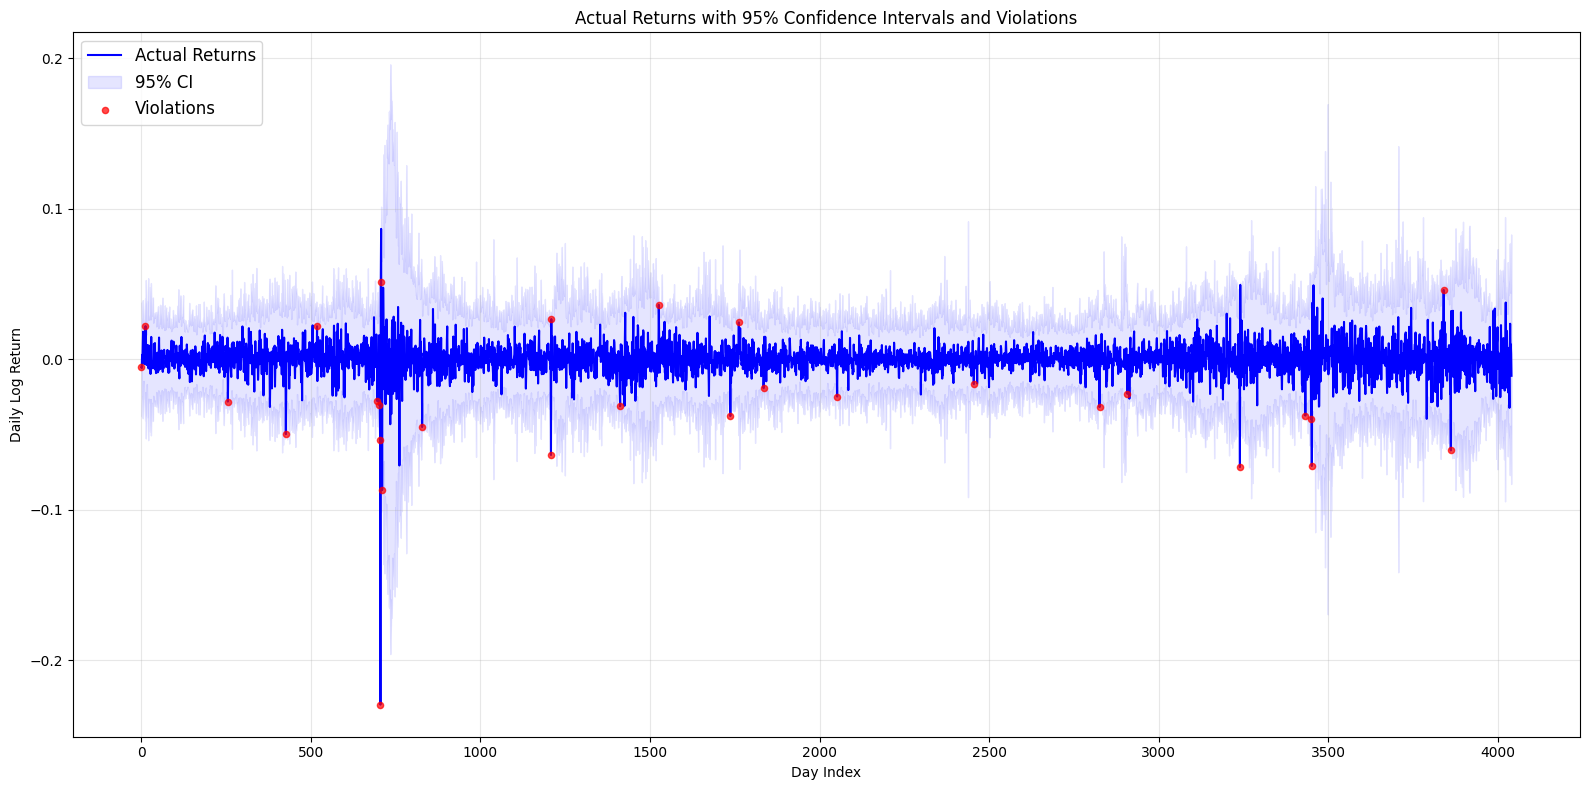

In [143]:
plt.figure(figsize=(16, 8))  

# Plot actual returns
plt.plot(range(sample_days), returns, label="Actual Returns", color="blue", linewidth=1.5)

# Add confidence interval 
plt.fill_between(range(sample_days), lower_bounds, upper_bounds, color="blue", alpha=0.1, label="95% CI")

# Highlight violations
violation_days = np.where((returns < lower_bounds) | (returns > upper_bounds))[0]
plt.scatter(violation_days, returns[violation_days], color="red", alpha = 0.7, label="Violations", zorder=5, s=20)

# Add labels, legend, and grid
plt.xlabel("Day Index")
plt.ylabel("Daily Log Return")
plt.title("Actual Returns with 95% Confidence Intervals and Violations")
plt.legend(fontsize=12, loc="upper left")
plt.grid(alpha=0.3)  

plt.tight_layout()
plt.show()

### Innovations Distribution Revisited

In this section, we revise the distribution of the standardized innovations derived from the GARCH model. The normal distribution underestimates the probability of extreme returns, while the Student's t-distribution captures the heavy tails more effectively, though it overestimates them. This observation is consistent with the observed violation rates from the confidence intervals.
The connection to the confidence intervals is clear: the **normal GARCH model**, due to its thinner tails, underestimates the likelihood of extreme values, leading to narrower confidence intervals and consequently more violations. In contrast, the **Student's t-GARCH model** accounts for heavier tails, resulting in wider confidence intervals. These wider intervals reduce the number of violations observed, as they are less likely to miss extreme events. This difference is visually supported by the graph, where the Student's t-distribution aligns better with the tails of the innovations compared to the normal distribution, but it tends to overestimate them.

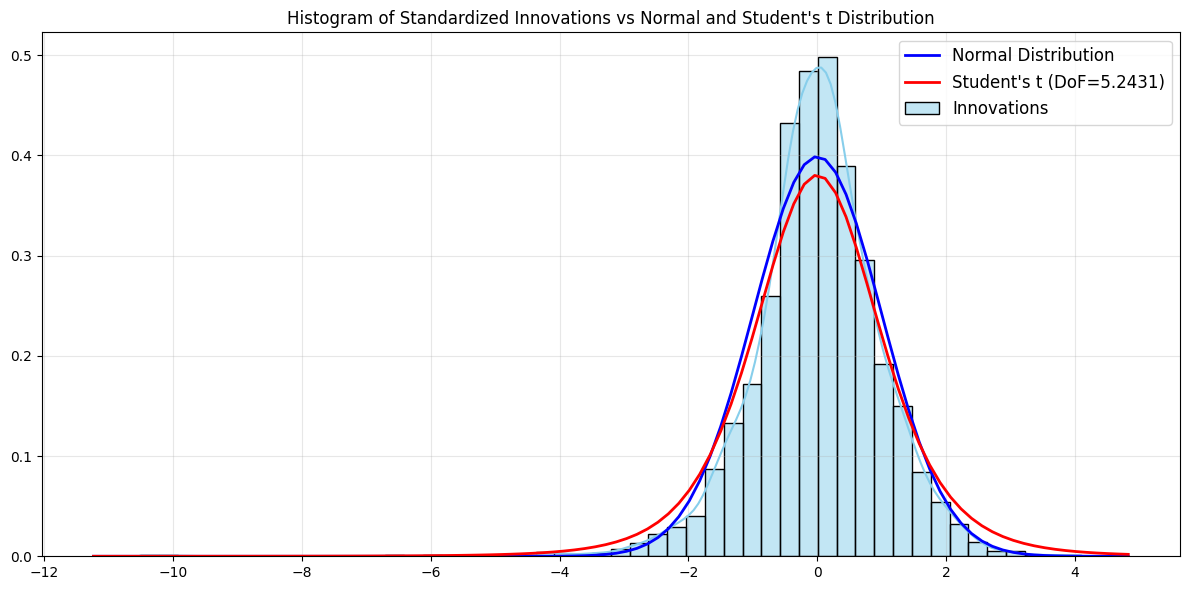

In [144]:
plt.figure(figsize=(12, 6))
sns.histplot(innovations, bins=50, kde=True, stat="density", color='skyblue', label="Innovations")

# Define x-axis range based on data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Normal distribution line 
pdf_normal = norm.pdf(x, 0, 1)  
plt.plot(x, pdf_normal, 'blue', linewidth=2, label="Normal Distribution")

# Student's t-distribution line with estimated degrees of freedom
nu = 5.243100  
pdf_student_t = t_distribution.pdf(x, df=nu)  
plt.plot(x, pdf_student_t, 'red', linewidth=2, label=f"Student's t (DoF={nu})")

# Add titles and labels
plt.title("Histogram of Standardized Innovations vs Normal and Student's t Distribution")
plt.ylabel('')  
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [145]:
# Double check degrees of freedom using the fit method
student_t_parameters_innovations = t_distribution.fit(innovations)
estimated_nu = student_t_parameters_innovations[0]

print(f"Fitted Degrees of Freedom: {estimated_nu}")

Fitted Degrees of Freedom: 5.267045173087384
